### [POC 1] NGLY1 deficiency graph extraction

This simple analysis demonstrates generic relation and entity extraction via language models from a short (~3.5k chars, ~800 tokens), dense description of the pathophysiology underlying NGLY1 deficiency.  Outline:

1. Use an LLM to extract a semi-structured graph of concepts related to NGLY1 deficiency
2. Identify those most relevant for early-stage drug development
3. Use an LLM to generate a structured graph representation (node-link JSON)
4. Analyze results

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import logging
import pandas as pd
import networkx as nx
from ngly1_gpt import utils, llm
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

#### Input

This is an opportune passage from [Prospective Phenotyping of NGLY1-CDDG, the First Congenital Disorder of Deglycosylation](https://pubmed.ncbi.nlm.nih.gov/27388694) (2020 - PMC7477955) that captures many characteristics of `NGLY deficiency` well:

In [2]:
disease = utils.NGLY1_DEFICIENCY
text = """
Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, and neopterin, Supplementary Figure S3). NAA may be found exclusively in neurons and declines as neurons become unhealthy or die. Elevations in choline could be consistent with a relative abundance of glial cells secondary to neuronal loss. Myo-inositol is a glia-specific marker that is elevated by gliosis or inflammation; in our cohort we do not have any evidence of inflammation. Creatine levels are relatively higher in glial cells compared to neurons. Taken together, the MRS findings suggest that there is a relative abundance of glial cells compared to neurons in the brain of NGLY1-CDDG individuals, possibly due to loss of neurons, and that the degree of this imbalance contributes significantly to the severity of the phenotype.

The impaired sweat response, largely affecting distal responses, is consistent with a small fiber neuropathy rather than a central etiology or generalized cholinergic dysfunction. Albumin CSF/serum quotient, or QAlb, is a marker of blood-CSF barrier dysfunction, and its value is inversely correlated to the CSF turnover rate. There was no significant change in the QAlb ratio (data not shown), arguing against increased turnover as a possible etiology. Regardless of the mechanism, we propose that decreased CSF protein and albumin concentrations represent a novel diagnostic marker for this disorder.

Individuals with NGLY1-CDDG and those with N-linked glycosylation disorders share the phenotypic features of low cholesterol, hepatopathy, peripheral neuropathy, retinal and optic nerve abnormalities, seizures, developmental delay with socialization as a relative strength, and delayed bone age. NGLY1-CDDG also overlaps with O-linked glycosylation disorders with respect to hypolacrima. There may be a pathogenic relationship; N-glycanase 1 catalyzes the cleavage of the amide bond between the proximal N-acetylglucosamine residue of glycans and the asparagine residue of the protein, so NGLY1-CDDG could impair glycan recycling and lead to hypoglycosylation. Indeed, the individuals with NGLY1-CDDG exhibited subtle abnormalities in transferrin and ApoC-III glycosylation.

Another hypothesis for the etiology of the NGLY1-CDDG phenotype is based on the fact that misfolded glycoproteins are processed through the endoplasmic reticulum associated degradation pathway (ERAD) and then retrotranslocated into the cytoplasm. There, N-glycanase is the first step in further degradation of these molecules, making ERAD dysfunction a possible pathophysiologic contributor especially given evidence of ER-stress in mouse embryonic fibroblasts. However, preliminary experiments found no impairment or enhancement of standard ERAD marker expression under normal conditions in NGLY1-CDDG patient fibroblasts (H.H. Freeze, personal communication, April 2016).
"""
print(text)


Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, and neopterin, Supplementary Figure S3). NAA may be found exclusively in neurons and declines as neurons become unhealthy

#### Extraction

First prompt to generate a semi-structured, natural language representation of the concepts, entities and relationships in the text.  In my experience, chain-of-thought prompting is at least as effective when doing this prior to prompting for a structured format in a final result, and it makes the final result more interpretable.  

You can see below that the model is prompted to identify biomedical concepts/relations **and** to classify those that comprise any sort of potential therapeutic opportunity:

In [3]:
graph_description = llm.extract_graph_description(text, disease=disease)
print(graph_description)

INFO:ngly1_gpt.llm:Prompt:
Text will be provided that contains information from a published, biomedical research article about NGLY1 deficiency. 

Extract all biological entities and processes that are hypothesized in this text as directly involved in the etiology of NGLY1 deficiency.  The intent of this extraction will ultimately be to create a graph (aka network) of these entities and processes as nodes with edges describing relations between them.  The focus will be on any proteins, genes, metabolites, pathways or other biological functions that are most likely to provide a means for chemical or physical intervention that may alter the course of the disease. 

Let's think step by step.  List the nodes first, and then the types of edges/relations, and then which of these constitute opportunities for intervention.

--- BEGIN TEXT ---

Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses reg

INFO:ngly1_gpt.llm:Response:
Nodes:
1. Neurons
2. Brain atrophy
3. Functional impairment
4. MRI
5. CSF metabolites (BH4, 5-HIAA, HVA)
6. Neurotransmitter producing neurons
7. Biochemical abnormalities
8. MRS results
9. NAA (N-acetylaspartate)
10. Choline
11. Myo-inositol
12. Creatine
13. Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)
14. Glial cells
15. Gliosis or inflammation
16. Sweat response
17. Small fiber neuropathy
18. Central etiology or generalized cholinergic dysfunction
19. Albumin CSF/serum quotient (QAlb)
20. CSF turnover rate
21. CSF protein and albumin concentrations
22. NGLY1-CDDG phenotype
23. Low cholesterol
24. Hepatopathy
25. Peripheral neuropathy
26. Retinal and optic nerve abnormalities
27. Seizures
28. Developmental delay with socialization as a relative strength
29. Delayed bone age
30. Hypolacrima
31. N-glycanase 1
32. Amide bond
33. Proximal N-acetylglucosamine
34. Glycans
35. Asparagine residue of the protein
36. Gycan recycling
37. Hypoglycosylati

Convert the above to JSON:

In [4]:
graph_json = llm.extract_graph_json(text, description=graph_description, disease=disease)
print(graph_json)

INFO:ngly1_gpt.llm:Prompt:
The following text contains information from a published, biomedical research article about NGLY1 deficiency:

--- BEGIN TEXT ---

Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransm

INFO:ngly1_gpt.llm:Response:
{
  "nodes": [
    {"id": 1, "label": "Neurons", "type": "Cell Type", "therapeutic": "Management"},
    {"id": 2, "label": "Brain atrophy", "type": "Condition", "therapeutic": "Management"},
    {"id": 3, "label": "Functional impairment", "type": "Symptom", "therapeutic": "Management"},
    {"id": 4, "label": "MRI", "type": "Diagnostic Tool", "therapeutic": "Unknown"},
    {"id": 5, "label": "CSF metabolites (BH4, 5-HIAA, HVA)", "type": "Molecular Function", "therapeutic": "Unknown"},
    {"id": 6, "label": "Neurotransmitter producing neurons", "type": "Cell Type", "therapeutic": "Management"},
    {"id": 7, "label": "Biochemical abnormalities", "type": "Symptom", "therapeutic": "Management"},
    {"id": 8, "label": "MRS results", "type": "Diagnostic Result", "therapeutic": "Unknown"},
    {"id": 9, "label": "NAA (N-acetylaspartate)", "type": "Metabolite", "therapeutic": "Unknown"},
    {"id": 10, "label": "Choline", "type": "Compound", "therapeutic": "Unkn

Load as networkx:

In [5]:
graph = llm.convert_graph_json(graph_json, disease=disease)
graph.number_of_nodes(), graph.number_of_edges()

(46, 65)

Show some info about the nodes in the graph:

In [6]:
node_info = pd.DataFrame([
    {**dict(id=id), **data} 
    for id, data in graph.nodes(data=True)
]).set_index('id', drop=False)
node_info

,id,label,type,therapeutic
id,,,,
1,1,Neurons,Cell Type,Management
2,2,Brain atrophy,Condition,Management
3,3,Functional impairment,Symptom,Management
4,4,MRI,Diagnostic Tool,Unknown
5,5,"CSF metabolites (BH4, 5-HIAA, HVA)",Molecular Function,Unknown
6,6,Neurotransmitter producing neurons,Cell Type,Management
7,7,Biochemical abnormalities,Symptom,Management
8,8,MRS results,Diagnostic Result,Unknown
9,9,NAA (N-acetylaspartate),Metabolite,Unknown


#### Analysis

Show nodes by therapeutic opportunity category where `Interventional` is the most actionable and `Management` implies symptoms or complications of the disease that could also be treated:

In [7]:
(
    node_info
    .pipe(lambda df: pd.concat([
        g['label'].rename(k)
        .pipe(lambda s: s.loc[s.str.len().sort_values(ascending=False).index])
        .to_frame().reset_index(drop=True)
        for k, g in df.groupby('therapeutic')
    ], axis=1))
    .fillna('')
)

,Interventional,Management,Unknown
0,Endoplasmic reticulum associated degradation pathway (ERAD),Developmental delay with socialization as a relative strength,"Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)"
1,ER-stress in mouse embryonic fibroblasts,Central etiology or generalized cholinergic dysfunction,CSF protein and albumin concentrations
2,Misfolded glycoproteins,Retinal and optic nerve abnormalities,"CSF metabolites (BH4, 5-HIAA, HVA)"
3,Hypoglycosylation,Neurotransmitter producing neurons,Asparagine residue of the protein
4,Gycan recycling,NGLY1-CDDG patient fibroblasts,Albumin CSF/serum quotient (QAlb)
5,N-glycanase 1,Biochemical abnormalities,Proximal N-acetylglucosamine
6,,Gliosis or inflammation,NAA (N-acetylaspartate)
7,,Small fiber neuropathy,ERAD marker expression
8,,Peripheral neuropathy,ApoC-III glycosylation
9,,Functional impairment,NGLY1-CDDG phenotype


Show nodes by type:

In [8]:
(
    node_info
    .pipe(lambda df: pd.concat([
        g['label'].rename(k)
        .pipe(lambda s: s.loc[s.str.len().sort_values(ascending=False).index])
        .to_frame().reset_index(drop=True)
        for k, g in df.groupby('type')
    ], axis=1))
    .pipe(lambda df: df[df.notnull().sum().sort_values().index])
    .fillna('')
)

,Biochemical Role,Phenotype,Cellular Component,Cellular Process,Composite,Molecular Structure,Molecular Process,Diagnostic Result,Metabolite,Diagnostic Tool,Protein,Disease,Physiological Process,Molecular Function,Compound,Cell Type,Symptom,Condition
0,Asparagine residue of the protein,NGLY1-CDDG phenotype,Cytoplasm,Endoplasmic reticulum associated degradation pathway (ERAD),Creatine,Amide bond,ApoC-III glycosylation,MRS results,NAA (N-acetylaspartate),Albumin CSF/serum quotient (QAlb),N-glycanase 1,NGLY1 deficiency,CSF turnover rate,"Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)",Proximal N-acetylglucosamine,Neurotransmitter producing neurons,Developmental delay with socialization as a relative strength,Central etiology or generalized cholinergic dysfunction
1,,,,,,,,,,MRI,Transferrin,Hepatopathy,Gycan recycling,CSF protein and albumin concentrations,Myo-inositol,NGLY1-CDDG patient fibroblasts,Biochemical abnormalities,ER-stress in mouse embryonic fibroblasts
2,,,,,,,,,,,,,Sweat response,"CSF metabolites (BH4, 5-HIAA, HVA)",Choline,Glial cells,Functional impairment,Retinal and optic nerve abnormalities
3,,,,,,,,,,,,,,ERAD marker expression,Glycans,Neurons,Hypolacrima,Gliosis or inflammation
4,,,,,,,,,,,,,,,,,Seizures,Misfolded glycoproteins
5,,,,,,,,,,,,,,,,,,Small fiber neuropathy
6,,,,,,,,,,,,,,,,,,Peripheral neuropathy
7,,,,,,,,,,,,,,,,,,Hypoglycosylation
8,,,,,,,,,,,,,,,,,,Delayed bone age
9,,,,,,,,,,,,,,,,,,Low cholesterol


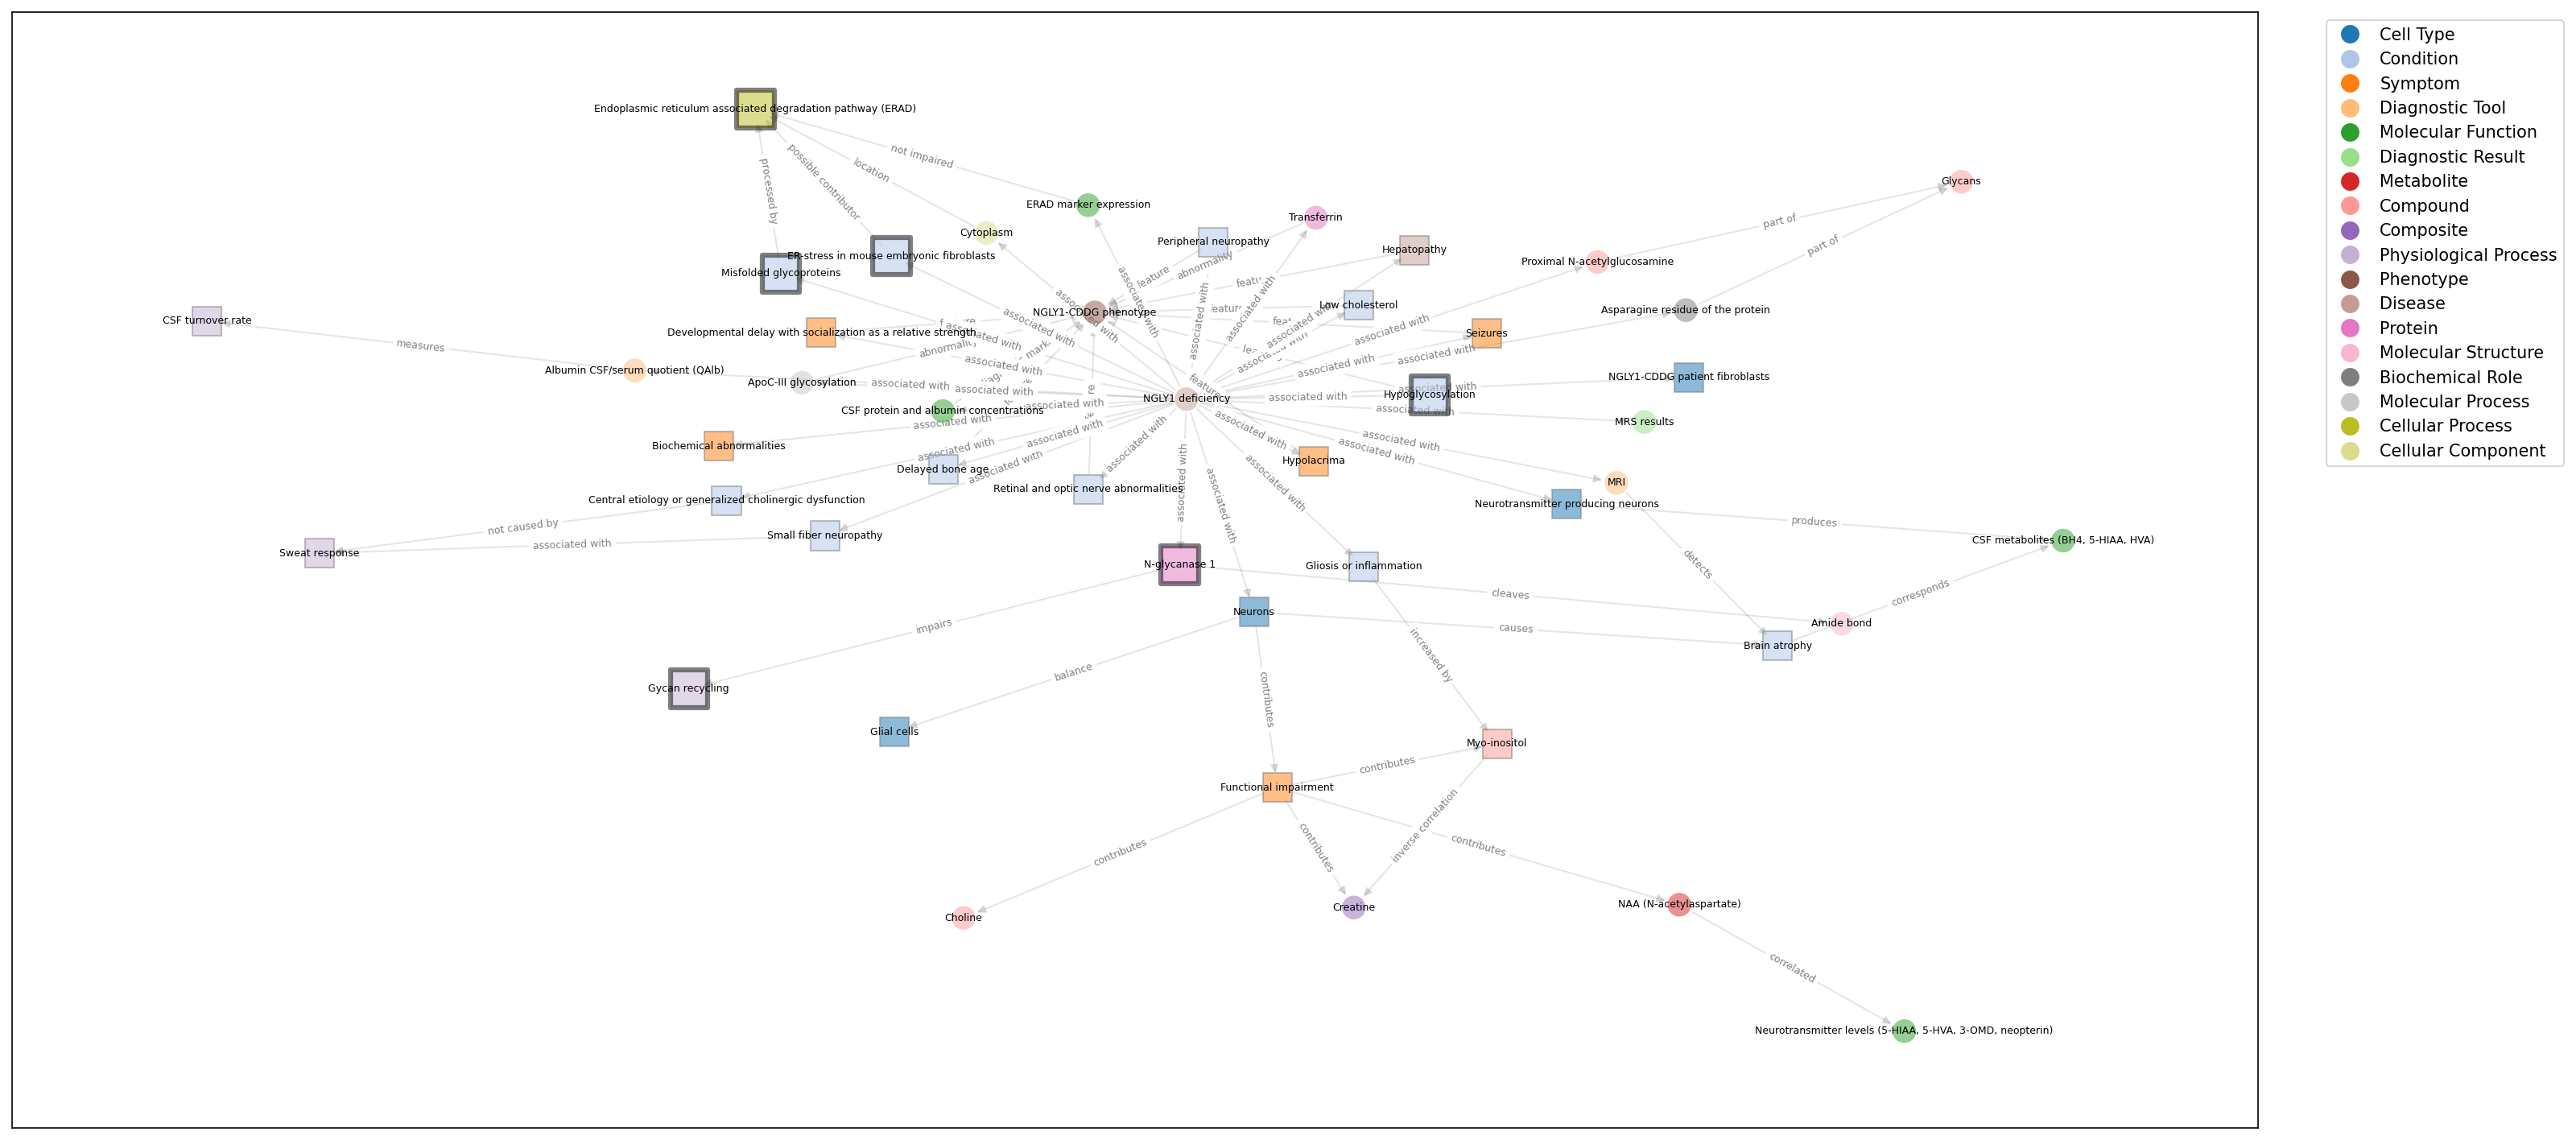

In [9]:
def plot_graph(graph, node_info):
    import matplotlib.pyplot as plt
    from networkx.drawing.nx_agraph import graphviz_layout
    from matplotlib.lines import Line2D
    plt.figure(figsize=(24, 12), dpi=150)
    pos = graphviz_layout(graph, prog="neato")
    cmap = utils.get_colormap(node_info["type"].unique(), cmap="tab20")
    node_color=node_info["type"].map(cmap).fillna('grey')
    node_config = {"Interventional": (3, "black", "s", 500), "Management": (1, "grey", "s", 300)}
    for k, g in node_info.groupby("therapeutic"):
        nodelist = g["id"].tolist()
        linewidths, edgecolors, node_shape, node_size = node_config.get(k, (0, "black", "o", 200))
        nx.draw_networkx_nodes(
            graph, pos, nodelist=nodelist, alpha=.5,
            linewidths=linewidths, edgecolors=edgecolors, node_shape=node_shape,
            node_size=node_size, node_color=node_color.loc[nodelist]
        )
    nx.draw_networkx_edges(graph, pos, alpha=.1)
    nx.draw_networkx_labels(graph, pos, labels={n: graph.nodes[n]["label"] for n in graph.nodes()}, font_size=6)
    nx.draw_networkx_edge_labels(graph, pos, alpha=.5, edge_labels={(e[0], e[1]): graph.edges[e].get("type", "None") for e in graph.edges}, font_size=6)

    plt.legend(handles=[
        Line2D([0], [0], marker='o', color=v, label=k, markerfacecolor=v, markersize=10, linewidth=0)
        for k, v in cmap.items()
    ], loc='upper right', bbox_to_anchor=(1.14, 1))
    plt.show()

from IPython.display import HTML
display(HTML(f"<h2>Pathophysiology decomposition ({disease})</h2>"))
plot_graph(graph, node_info)
display(HTML(
    "<strong>Note</strong>: Larger squares with darker borders represent "
    "terms classified by the LLM as most likely to be applicable for therapeutic intervention.  Smaller squares with "
    "lighter borders represent symptoms/conditions that might also be managed by drugs.  Circles represent everything else."
))